In [1]:
import os
import sys
import time
import errno

import numpy as np
import scipy as scp
import pandas as pd
import seaborn as sns

In [2]:
import numba
from numba import jit

In [3]:
import torch
import sbi
import sbi.inference
from sbi.inference import SNPE, prepare_for_sbi ,simulate_for_sbi
from sbi.inference.base import infer
from sbi.analysis import ActiveSubspace, pairplot
import sbi.utils as utils

In [4]:
# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
from IPython.display import HTML

In [5]:
from typing import Any, Callable, Dict, List, Optional, Tuple, Union, cast

In [6]:
%pylab inline
#%matplotlib notebook

plt.style.use('seaborn-talk');

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/meysam/.local/lib/python3.8/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['cast']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +
/tmp/ipykernel_454718/94587667.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-talk');


In [7]:
print(f"Numpy version: {np.__version__}")
print(f"Numba version: {numba.__version__}")
print(f"Matplotlib` version: {matplotlib.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"SciPy version: {scp.__version__}")
print(f"SBI version: {sbi.__version__}")

Numpy version: 1.24.4
Numba version: 0.57.1
Matplotlib` version: 3.7.1
Pandas version: 2.0.2
SciPy version: 1.10.1
SBI version: 0.21.0


In [8]:
cwd = os.getcwd()
cwd

'/mnt/0582b5ea-dc43-4c17-8a69-29b39f3fc394/SBI/MPR_NMM_SBI'

In [9]:
Res_dir='Res_SBI_NMM_MPR_ODE_Istep_Vfeatures_sumstatspeaks_100ksims_v21'

In [10]:
import warnings
warnings.filterwarnings("ignore")

# Simulation of Montbrio model


$\dfrac{dr}{dt} = 2rv +\Delta/\pi$

$ \dfrac{dv}{dt} = v^2  -\pi^2 r^2 + Jr+ \eta +I(t) $


In [11]:
def Montbrio_ODEmodel(params, constants, I_input, dt, ts):
   
    #parameters
    delta, eta, J  = params[0], params[1], params[2]
    sigma=0.0
    dt = float(dt) #Euler inetgration

    # simulation from initial point
    v = np.zeros_like(ts)  # membrane potential
    r = np.zeros_like(ts)  # firing rate

    # fixed parameters (initial conditions)
    v_init, r_init=constants[0], constants[1]
    v[0],r[0]= v_init, r_init

    for i in range(1, ts.shape[0]):
        dr =(delta/np.pi) +2.*r[i-1]*v[i-1]
        dv = v[i-1]**2  -(np.pi*r[i-1])**2 + J*r[i-1]+ eta +I_input[i-1]
        v[i]=v[i-1] + dt * dv + np.sqrt(dt) * sigma * np.random.randn() 
        r[i]=r[i-1] + dt * dr + np.sqrt(dt) * sigma * np.random.randn() 
        
    return np.concatenate((np.array(v).reshape(-1), np.array(r).reshape(-1),))
     

In [12]:
Montbrio_ODEmodel_numba = numba.jit(Montbrio_ODEmodel)

In [13]:
delta=0.7
eta=-4.6
J=14.5
sigma=0.0

In [14]:
eta/delta, J/np.sqrt(delta)

(-6.571428571428571, 17.330814835348708)

In [15]:
params=[delta, eta, J]

In [16]:
t_init = 0.0
t_final = 100.0

dt = 0.001
ts = np.arange(t_init,t_final,dt)

nt=ts.shape[0]

In [17]:
nIsteps = int((t_final - t_init)/dt)
nIsteps

100000

In [18]:
I0=3.
t_on=30.
t_off=60.

In [19]:
I_input=[]
I_input = [0 for i in range(int((t_on - t_init)/dt))]+ [I0 for i in range(int((t_off - t_on)/dt))]+ [0 for i in range(int((t_final - t_off)/dt))]

In [20]:
I_input =np.asarray(I_input)

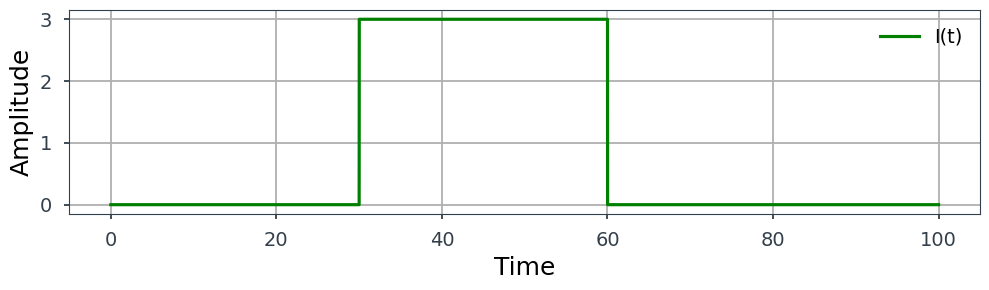

In [21]:
plt.figure(figsize=(10, 3))
plt.plot(ts, I_input,color='g' , label='I(t)')
plt.xlabel('Time', fontsize=18); 
plt.ylabel('Amplitude', fontsize=18); 
plt.legend(loc='upper right', fontsize=14, frameon=False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.tight_layout()
plt.show()

In [22]:
v0 = -3.0
r0 = 0.5

In [23]:
constants=[v0, r0]

In [24]:
start_time = time.time()

rv = Montbrio_ODEmodel(params, constants, I_input, dt, ts)

print ("-"*60)
print("--- %s seconds ---" % (time.time() - start_time))

------------------------------------------------------------
--- 0.4912111759185791 seconds ---


In [25]:
## first run using JIT numba takes time due to compilation, but then in is in fly!

In [26]:
start_time = time.time()

rv = Montbrio_ODEmodel_numba(params, constants, I_input, dt, ts)

print ("-"*60)
print("--- %s seconds ---" % (time.time() - start_time))

------------------------------------------------------------
--- 1.7083477973937988 seconds ---


In [27]:
start_time = time.time()

rv = Montbrio_ODEmodel_numba(params, constants, I_input, dt, ts)

print ("-"*60)
print("--- %s seconds ---" % (time.time() - start_time))

------------------------------------------------------------
--- 0.010552406311035156 seconds ---


In [28]:
v=rv[0:nt]
r=rv[nt:2*nt]

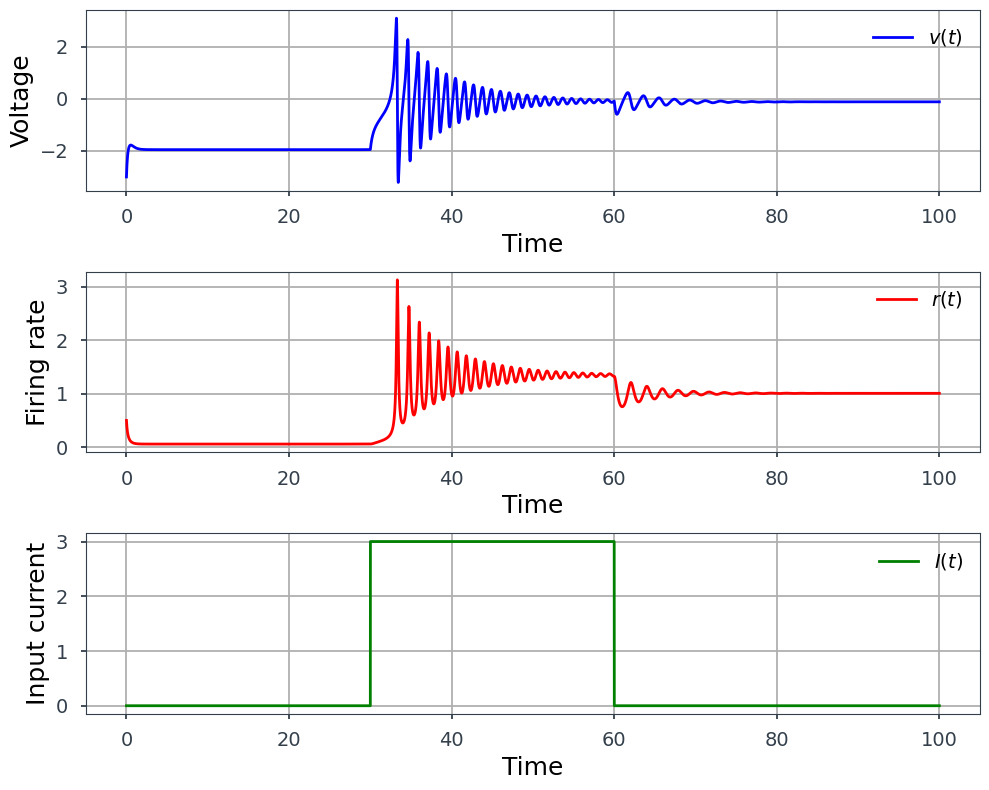

In [29]:
plt.figure(figsize=(10, 8))

plt.subplot(311)
plt.plot(ts, v, 'b', linewidth=2, label='$v(t)$')
plt.xlabel('Time', fontsize=18); plt.ylabel('Voltage', fontsize=18); 
plt.legend(loc='upper right', fontsize=14, frameon=False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.grid()

plt.subplot(312)
plt.plot(ts, r, 'r', linewidth=2, label='$r(t)$')
plt.xlabel('Time', fontsize=18); plt.ylabel('Firing rate', fontsize=18); 
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=14, frameon=False)
plt.tight_layout()
plt.grid()

plt.subplot(313)
plt.plot(ts, I_input, 'g', linewidth=2, label='$I(t)$')
plt.xlabel('Time', fontsize=18); plt.ylabel('Input current', fontsize=18); 
plt.legend(loc='upper right', fontsize=14, frameon=False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.grid()

plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_ode_Istep.png"), dpi=300)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_ode_Istep.eps"), dpi=300)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_ode_Istep.svg"), dpi=300)

plt.show()

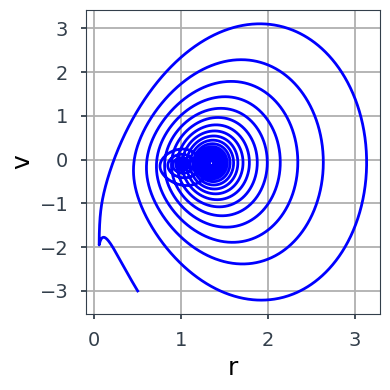

In [30]:
plt.figure(figsize=(4, 4))
plt.plot(r, v, 'b', linewidth=2)
plt.ylabel('v', fontsize=18); 
plt.xlabel('r', fontsize=18);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.grid()

# Features

In [31]:
from scipy.signal import  find_peaks

In [32]:
v_act=v[(ts > t_on) & (ts < t_off)]
peaks, _ = find_peaks(v_act, height=.2, distance=1000)
peaks

array([ 3209,  4610,  5867,  7061,  8218,  9354, 10475, 11588, 12695,
       13798, 14898, 15997, 17094])

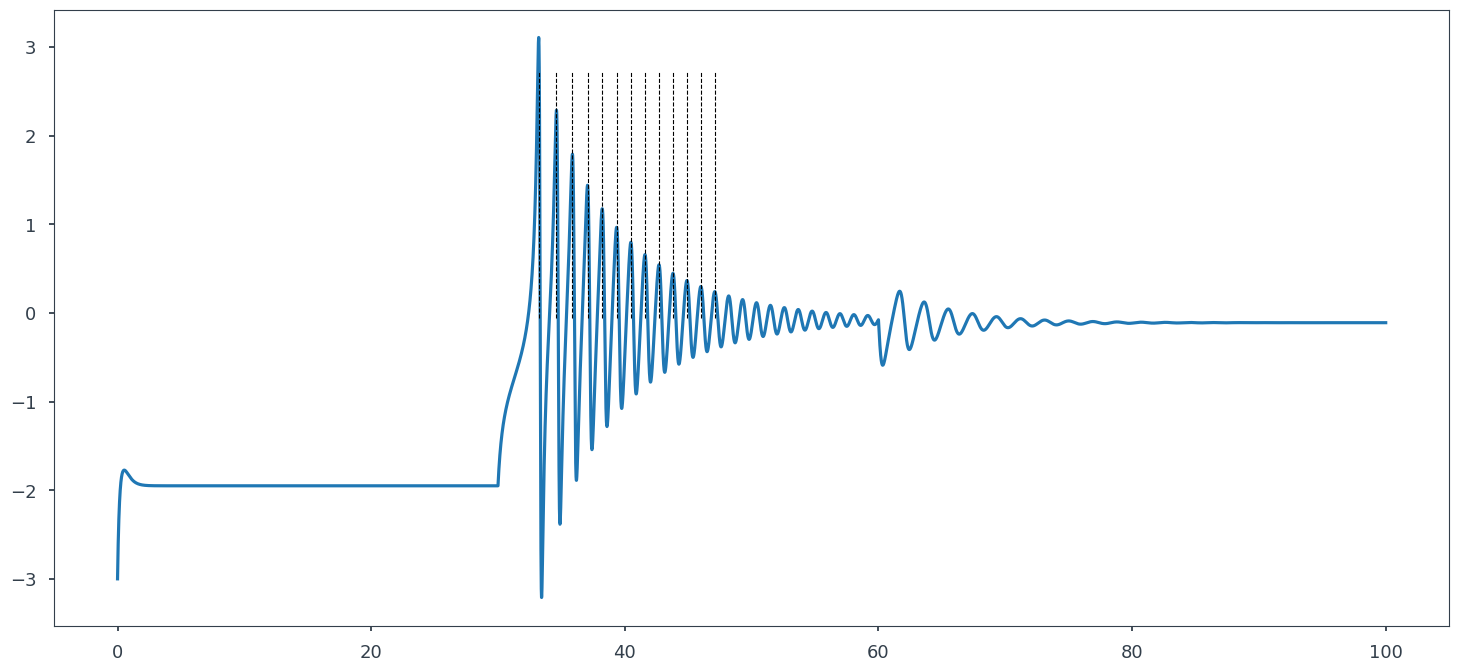

In [33]:
plt.figure(figsize=(18, 8))

plt.plot(ts,v)
for i in np.r_[0:len(peaks)]:
     plt.axvline(x=t_on+dt*peaks[i], ymin=.5, ymax=.9, linewidth=.8, color = 'k', linestyle='--')


In [34]:
from MPR_NMM_sumstats import calculate_summary_statistics

In [35]:
_=calculate_summary_statistics(v, dt, ts, t_on, t_off)

In [36]:
_

array([-1.94862515e+00,  4.94874504e-02, -1.95036874e+00, -1.08410045e+01,
        1.86733085e+02, -1.24185576e-01,  6.94910192e-01, -1.01817910e-01,
        1.13177559e-01,  4.12548604e+00, -1.14703068e-01,  8.48519127e-02,
       -1.10529037e-01, -1.13297893e+00,  1.03623192e+01,  1.30000000e+01,
        3.32090000e+01])

## 1. Simulator


The wrapper takes only parameters as the input and return the features (summary statistics) or raw time series as the output, the later case if we like to save the simulations and then load them and calculate the corresponding features.

In [37]:
def Montbrio_ODEmodel_Wrapper(params):

    params = np.asarray(params)
    
    t_init = 0.0
    t_final = 100.0

    dt = 0.001
    ts = np.arange(t_init,t_final,dt)
    nt=ts.shape[0]
    nIsteps = int((t_final - t_init)/dt)

    I0=3.
    t_on=30.
    t_off=60.

    I_input=[]
    I_input = [0 for i in range(int((t_on - t_init)/dt))]+ [I0 for i in range(int((t_off - t_on)/dt))]+ [0 for i in range(int((t_final - t_off)/dt))]
    I_input =np.asarray(I_input)

    v0 = -3.0
    r0 = 0.5
    
    constants=[v0, r0]
    
    rv = Montbrio_ODEmodel_numba(params, constants, I_input, dt, ts)
    v=rv[0:nt]
    
    summstats = torch.as_tensor(calculate_summary_statistics(v.reshape(-1), dt, ts, t_on, t_off))
    return summstats
  

In [38]:
delta_true=0.7
eta_true=-4.6
J_true=14.5
sigma=0.0

In [39]:
params_true=[delta_true, eta_true, J_true]
params_true

[0.7, -4.6, 14.5]

In [40]:
Montbrio_ODEmodel_Wrapper(params_true).shape

torch.Size([17])

In [41]:
rv = Montbrio_ODEmodel_numba(params_true, constants, I_input,  dt, ts)
v=rv[0:nt]
r=rv[nt:2*nt]

In [42]:
ts.shape, v.shape, r.shape

((100000,), (100000,), (100000,))

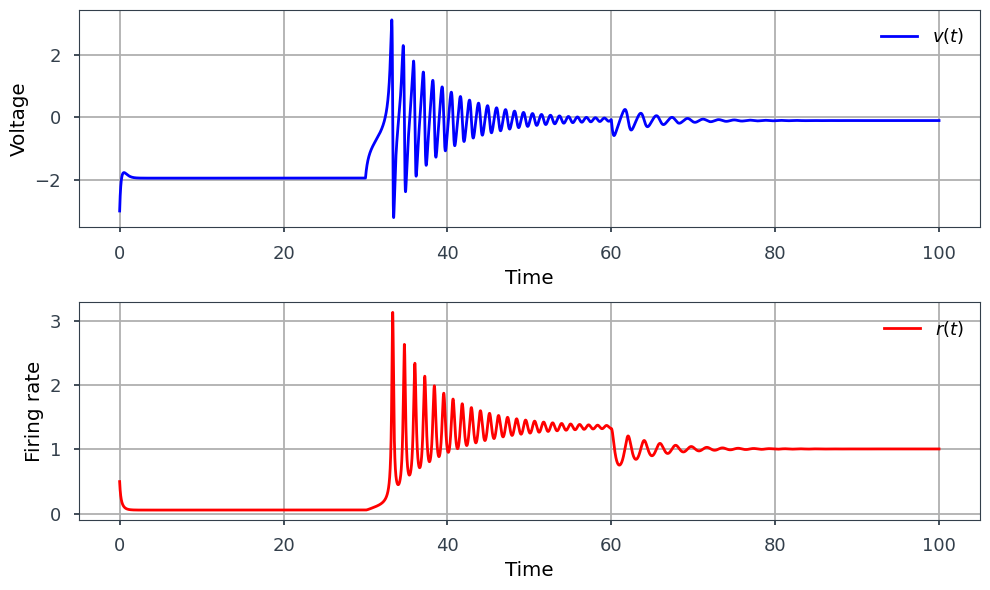

In [43]:
plt.figure(figsize=(10, 6))
plt.subplot(211)
plt.plot(ts, v, 'b', linewidth=2, label='$v(t)$')
plt.xlabel('Time'); plt.ylabel('Voltage'); 
plt.legend(loc='upper right', frameon=False)
plt.tight_layout()
plt.grid()

plt.subplot(212)
plt.plot(ts, r, 'r', linewidth=2, label='$r(t)$')
plt.xlabel('Time'); plt.ylabel('Firing rate'); 
plt.legend(loc='upper right', frameon=False)
plt.tight_layout()
plt.grid()
plt.show()

## 2. Prior over model parameters


In [44]:
prior_min = [0.1, -10., 5.0]
prior_max = [5.0, -3.0, 20.]
prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max))

In [45]:
prior.sample()

tensor([ 2.1532, -8.7209, 19.6020])

In [46]:
num_params=prior.sample().shape[0]
num_params

3

### 3. Inference

In [47]:
num_sims=100000

In [48]:
# 1-step simualtion, calculation of features, and inference

start_time = time.time()

posterior = infer(Montbrio_ODEmodel_Wrapper, prior, method='SNPE', num_simulations=num_sims, num_workers=1)

print ("-"*60)
print("--- %s seconds ---" % (time.time() - start_time))

Running 100000 simulations.:   0%|          | 0/100000 [00:00<?, ?it/s]

 Neural network successfully converged after 167 epochs.------------------------------------------------------------
--- 5082.270807981491 seconds ---


### Observed Data

In [49]:
params_label=np.array(['delta', 'eta', 'J'])
params_label=np.array(['$\Delta$', '$\eta$', '$J$'])

In [50]:
delta_true=0.7
eta_true=-4.6
J_true=14.5

true_params = np.array([delta_true, eta_true, J_true])

In [51]:
x_obs= Montbrio_ODEmodel_numba(true_params, constants, I_input, dt, ts)
v_obs=x_obs[0:nt]
r_obs=x_obs[nt:2*nt]
x_obs_summary_statistics=calculate_summary_statistics(v_obs.reshape(-1), dt, ts, t_on, t_off)

In [52]:
x_obs_summary_statistics.shape

(17,)

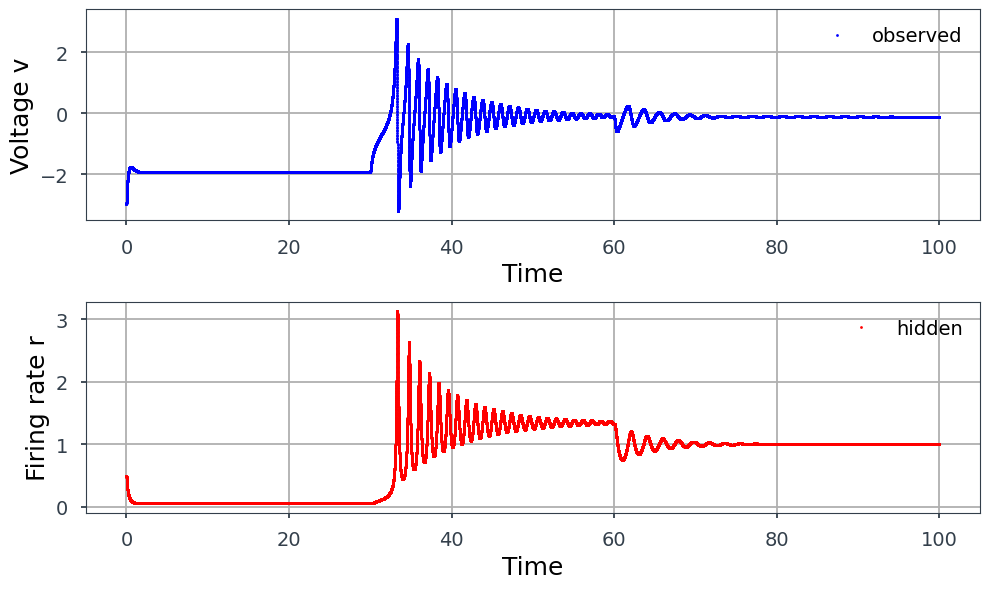

In [53]:
plt.figure(figsize=(10, 6))
plt.subplot(211)
plt.plot(ts, v_obs, '.',  markersize=4, color='blue', label='observed')
plt.xlabel('Time', fontsize=18)
plt.ylabel('Voltage v', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right',fontsize=14, frameon=False)
plt.tight_layout()
plt.grid()

plt.subplot(212)
plt.plot(ts, r_obs, '.',  markersize=4, color='red',label='hidden')
plt.xlabel('Time', fontsize=18)
plt.ylabel('Firing rate r',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=14, frameon=False)
plt.tight_layout()
plt.grid()

plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_ode_obs.png"), dpi=300)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_ode_obs.eps"), dpi=300)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_ode_obs.svg"), dpi=300)
plt.show()

### Posterior

In [54]:
num_samples=10000

In [55]:
posterior_samples = posterior.sample((num_samples,), x_obs_summary_statistics).numpy()

posterior_samples.shape

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

(10000, 3)

In [56]:
delta_est=posterior_samples[:,0]
eta_est=posterior_samples[:,1]
J_est=posterior_samples[:,2]

In [57]:
print("delta_est=", delta_est.mean())
print("eta_est=", eta_est.mean())
print("J_est=", J_est.mean())

delta_est= 0.75117487
eta_est= -4.6779847
J_est= 14.846582


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


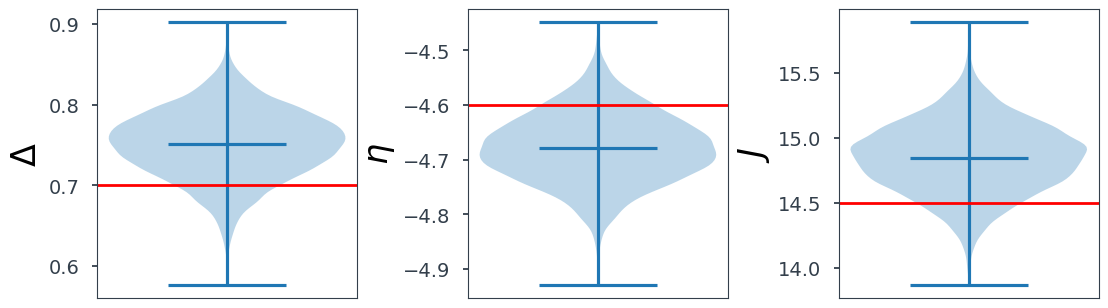

In [58]:
plt.figure(figsize=(11, 3))
for i, variables in enumerate([delta_est, eta_est, J_est]):
    plt.subplot(1,params_label.shape[0],i+1)
    plt.violinplot(variables, widths=0.7, showmeans=True, showextrema=True);
    plt.axhline(y=true_params[i], linewidth=2, color='r')
    plt.ylabel(str(params_label[i]), fontsize=24)   
    plt.xticks([])
    plt.yticks(fontsize=14)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "PosteriorViloin_Monbtbrio_NMM_ode_EstimatedParams_obs.png"), dpi=300)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "PosteriorViloin_Monbtbrio_NMM_ode_EstimatedParams_obs.eps"), dpi=300)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "PosteriorViloin_Monbtbrio_NMM_ode_EstimatedParams_obs.svg"), dpi=300)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


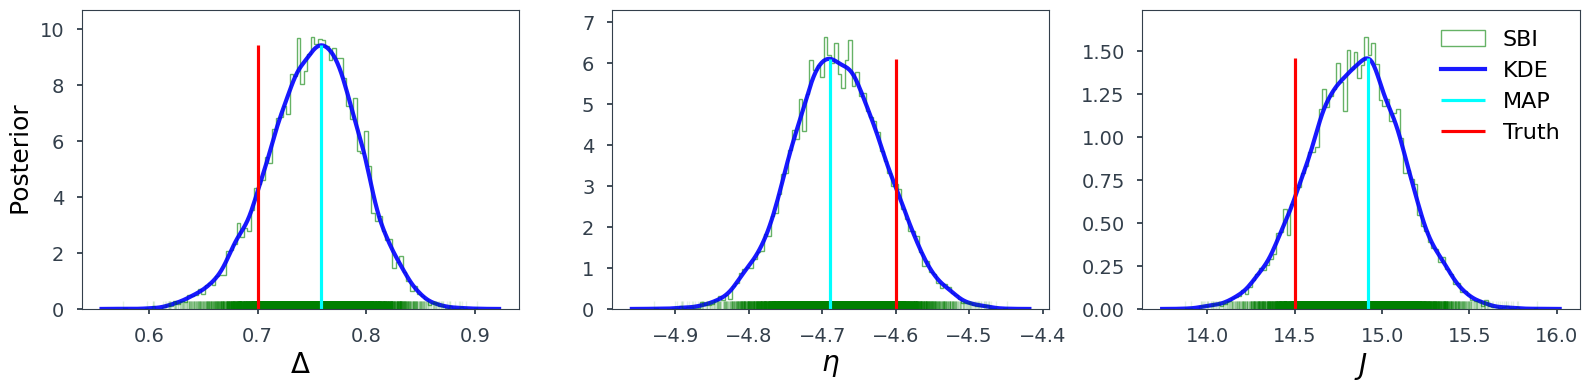

In [59]:
plt.figure(figsize=(16, 4))

for i in range (num_params): 
    ax = plt.subplot(1, 3, i + 1)
    ax=sns.distplot(posterior_samples[:,i], bins=100, hist=True, kde=True, rug=True, rug_kws={"alpha": 0.1, "color": "g"},
                  kde_kws={"color": "b", "alpha": 0.9, "lw": 3, "label": "KDE"},
                  hist_kws={"histtype": "step", "linewidth": 1, "alpha": 0.6, "color": "g"},
                  label='SBI')

    x_ = ax.lines[0].get_xdata()
    y_ = ax.lines[0].get_ydata()
    ymax = max(y_)
    xpos = np.argmax(y_, axis=0)
    xmax = x_[xpos]
    plt.vlines(x=xmax, ymin=0., ymax=y_.max(), colors='cyan', label='MAP')
    plt.vlines(x=true_params[i], ymin=0., ymax=y_.max(), colors='r', label='Truth')

    plt.xlabel(str(params_label[i]), fontsize=20)   
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    if i==0:
        plt.ylabel(' Posterior ', fontsize=18);  
    else:
        plt.ylabel('')
        
    if i==2:
            plt.legend(fontsize=16, frameon=False)
 
plt.tight_layout(pad=1.0)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Posterior_Monbtbrio_NMM_ode_EstimatedParams_obs.png"), dpi=300)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Posterior_Monbtbrio_NMM_ode_EstimatedParams_obs.eps"), dpi=300)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Posterior_Monbtbrio_NMM_ode_EstimatedParams_obs.svg"), dpi=300)

plt.show()

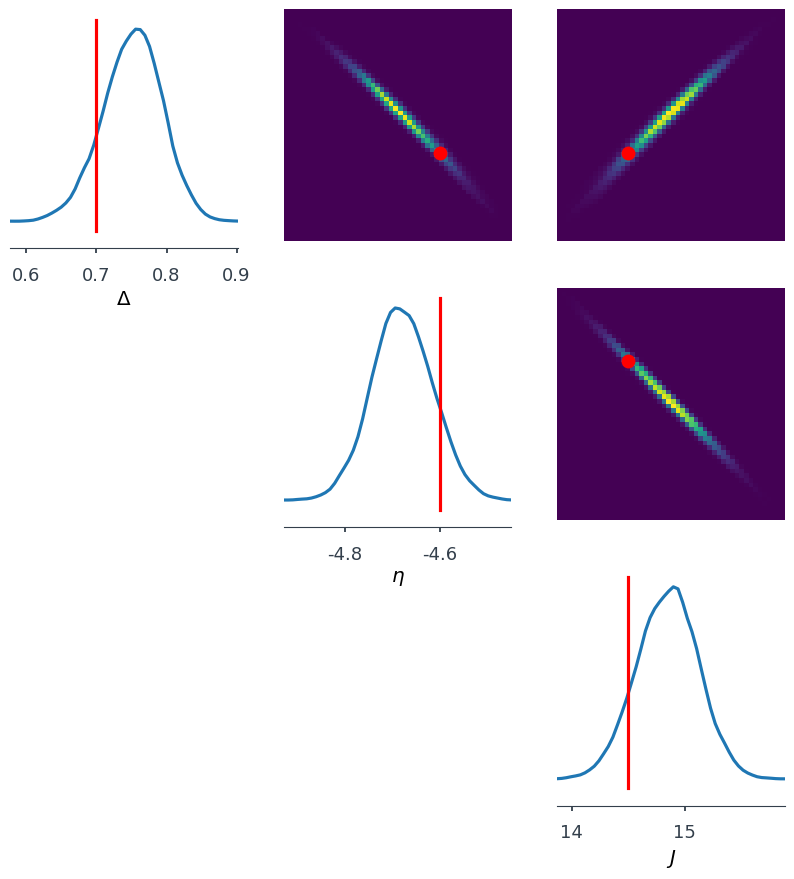

In [60]:
fig, axes = pairplot(posterior_samples,
                           fig_size=(8,8),
                           labels=params_label,
                           upper=['kde'],
                           diag=['kde'],
                           points=true_params,
                           points_offdiag={'markersize': 20},
                           points_colors='r');
            
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_ode_posterior_pairplot_obs.png"), dpi=300)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_ode_posterior_pairplot_obs.eps"), dpi=300)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_ode_posterior_pairplot_obs.svg"), dpi=300)
plt.show()


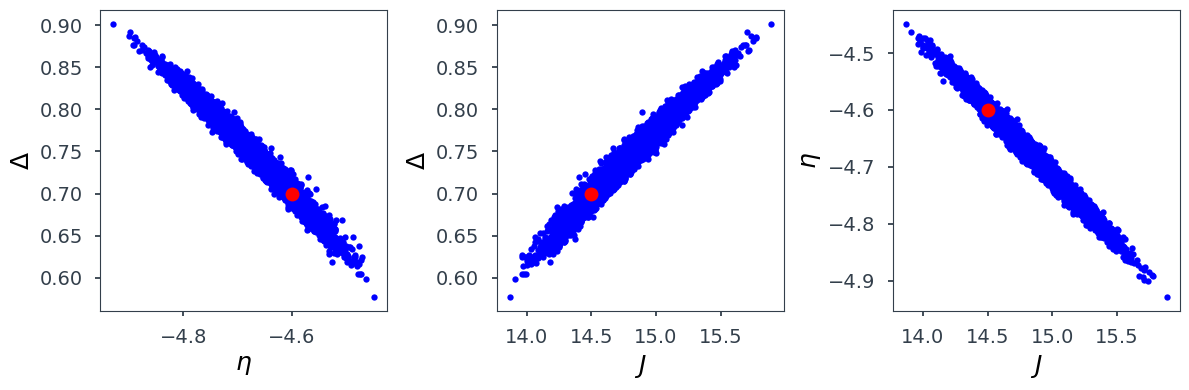

In [61]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.plot(eta_est, delta_est,'.', color='blue')
plt.plot(eta_true, delta_true,'o', color='red', markersize=10)
plt.xlabel("$\eta$", fontsize=18)
plt.ylabel("$\Delta$", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.subplot(132)
plt.plot(J_est, delta_est, '.',color='blue')
plt.plot(J_true, delta_true, 'o', color='red', markersize=10)
plt.xlabel("$J$", fontsize=18)
plt.ylabel("$\Delta$",fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.subplot(133)
plt.plot(J_est, eta_est, '.', color='blue')
plt.plot(J_true, eta_true, 'o', color='red', markersize=10)
plt.xlabel("$J$", fontsize=18)
plt.ylabel("$\eta$", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_ode_posterior_PairParamsJoindist_obs.png"), dpi=300)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_ode_posterior_PairParamsJoindist_obs.eps"), dpi=300)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_ode_posterior_PairParamsJoindist_obs.svg"), dpi=300)

plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


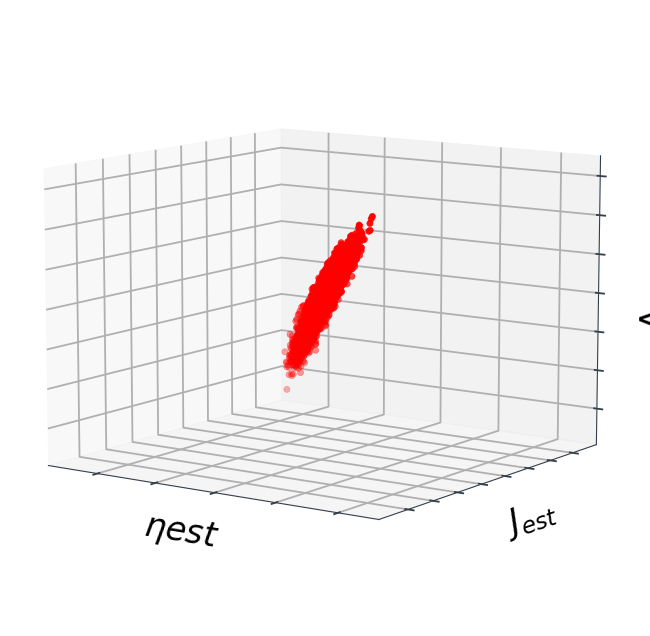

In [62]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
x =eta_est
y =J_est
z =delta_est
ax.scatter(x, y, z, c='red', marker='o')
ax.set_xlabel("$\eta{est}$", fontsize=24)
ax.set_ylabel("$J_{est}$", fontsize=24)
ax.set_zlabel("$\Delta_{est}$", fontsize=24)
ax.grid(True)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.view_init(10, 125)
plt.tight_layout()

plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_ode_posterior_Joint3Dpairplot_obs.png"), dpi=300)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_ode_posterior_Joint3Dpairplot_obs.eps"), dpi=300)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_ode_posterior_Joint3Dpairplot_obs.svg"), dpi=300)
plt.show()

In [63]:
delta_est=array([delta_est]).T
eta_est=array([eta_est]).T
J_est=array([J_est]).T

In [64]:
params = {'delta_est': delta_est, 'eta_est': eta_est, 'J_est': J_est}
        
f=concatenate((delta_est, eta_est, J_est), axis=1)

df = pd.DataFrame(f, columns=['delta_est',  'eta_est', 'J_est' ])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


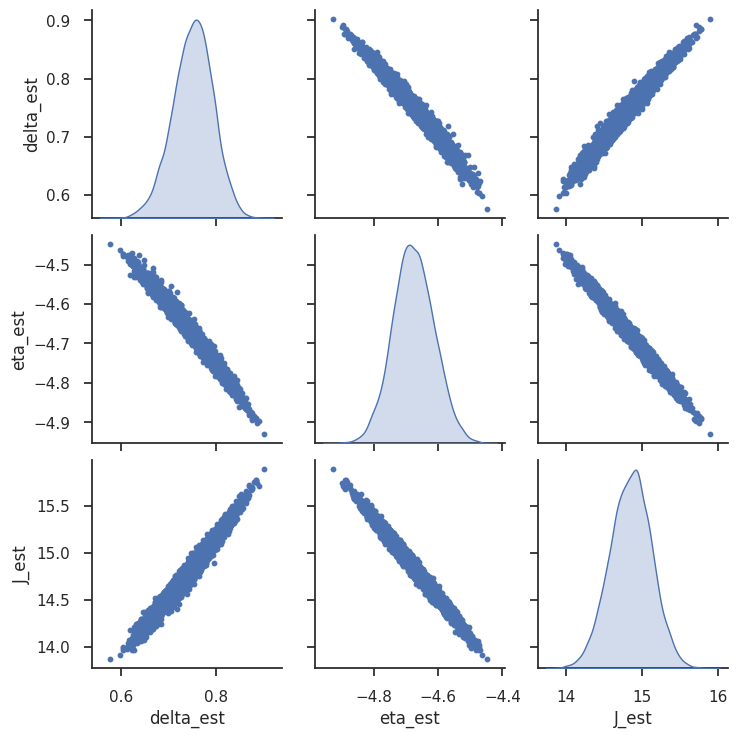

In [65]:
import seaborn as sns; sns.set(style="ticks", color_codes=True)
g = sns.pairplot(df, diag_kind="kde", markers="o",plot_kws=dict(s=10, edgecolor="b", linewidth=1))
#g.set(xticklabels=[])
#g.set(yticklabels=[])
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_ode_posterior_PairParamsScatterdist3d_obs.png"), dpi=300)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_ode_posterior_PairParamsScatterdist3d_obs.eps"), dpi=300)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_ode_posterior_PairParamsScatterdist3d_obs.svg"), dpi=300)
plt.show()

In [66]:
df.corr()

,delta_est,eta_est,J_est
delta_est,1.000000,-0.986994,0.983212
eta_est,-0.986994,1.000000,-0.990541
J_est,0.983212,-0.990541,1.000000


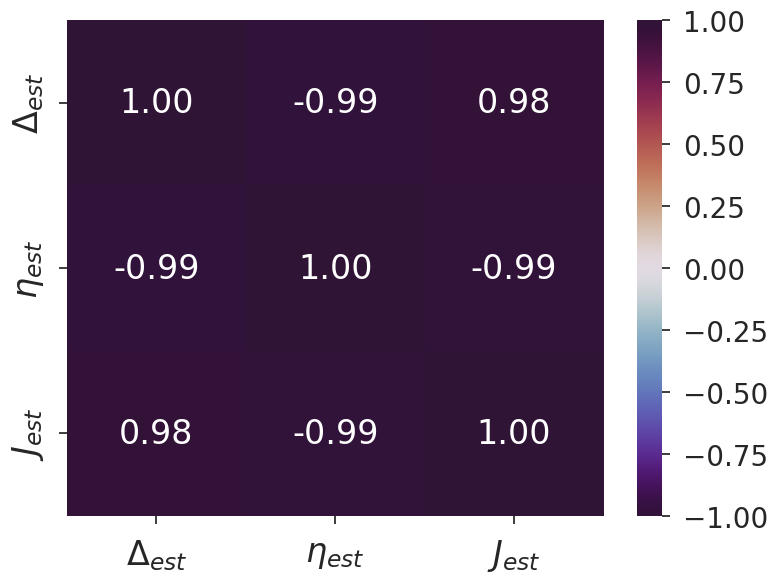

In [67]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
#cmap = sns.diverging_palette(240, 10, sep=20, as_cmap=True)
sns.heatmap(df.corr(), annot=True, robust=True, cmap='twilight_shifted', linewidths=.0, annot_kws={'size':24}, fmt=".2f", vmin=-1, vmax=1, ax=ax, xticklabels=['$\Delta_{est}$', '$\eta_{est}$', '$J_{est}$' ], yticklabels=['$\Delta_{est}$', '$\eta_{est}$', '$J_{est}$' ])
#ax.set_xticklabels()
#ax.set_yticklabels()
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
ax.tick_params(labelsize=24)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_ode_posterior_CorrParams_obs.png"), dpi=300)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_ode_posterior_CorrParams_obs.eps"), dpi=300)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_ode_posterior_CorrParams_obs.svg"), dpi=300)
plt.show()

In [68]:
x_fit= Montbrio_ODEmodel_numba(np.percentile(posterior_samples, [50], axis=0).reshape(-1), constants, I_input, dt, ts)
v_fit=x_fit[0:nt]
r_fit=x_fit[nt:2*nt]

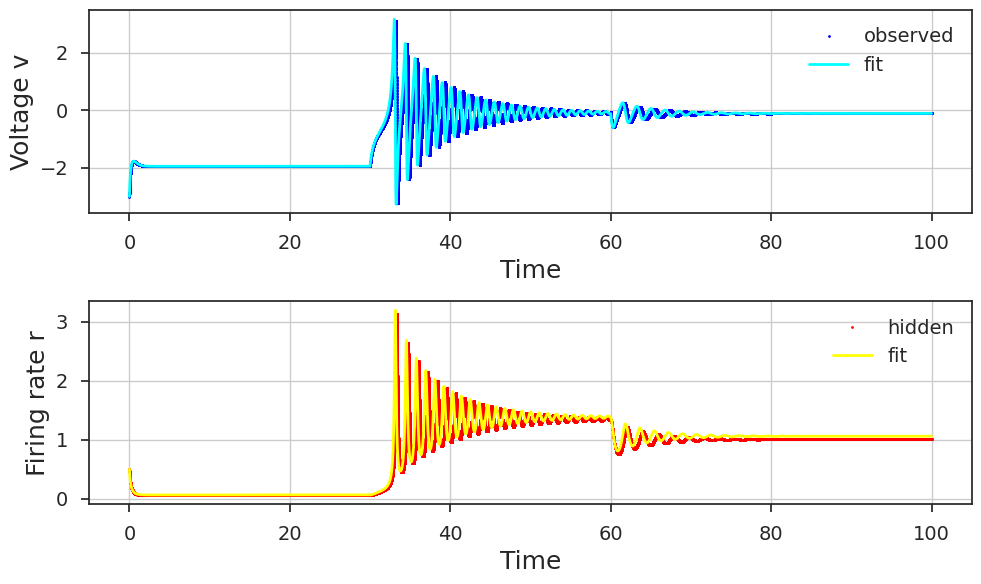

In [69]:
plt.figure(figsize=(10, 6))
plt.subplot(211)
plt.plot(ts, v_obs, '.',  markersize=4, color='blue', label='observed')
plt.plot(ts, v_fit, lw=2, color='cyan', label='fit')
plt.xlabel('Time', fontsize=18)
plt.ylabel('Voltage v', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right',fontsize=14, frameon=False)
plt.tight_layout()
plt.grid()

plt.subplot(212)
plt.plot(ts, r_obs, '.',  markersize=4, color='red',label='hidden')
plt.plot(ts, r_fit, lw=2, color='yellow', label='fit')
plt.xlabel('Time', fontsize=18)
plt.ylabel('Firing rate r',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=14, frameon=False)
plt.tight_layout()
plt.grid()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_ode_fit_obs.png"), dpi=300)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_ode_fit_obs.eps"), dpi=300)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_ode_fit_obs.svg"), dpi=300)
plt.show()

In [70]:
alpha_true=eta_true/delta_true
alpha_est=eta_est/delta_est

beta_true=J_true/sqrt(delta_true)
beta_est=J_est/sqrt(delta_est)

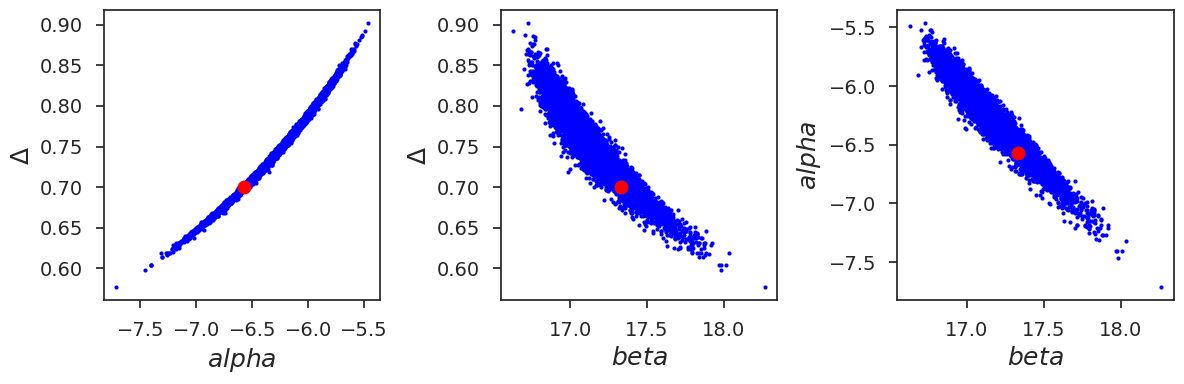

In [71]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.plot(alpha_est, delta_est,'.', color='blue')
plt.plot(alpha_true, delta_true,'o', color='red', markersize=10)
plt.xlabel("$alpha$", fontsize=18)
plt.ylabel("$\Delta$", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.subplot(132)
plt.plot(beta_est, delta_est, '.', color='blue')
plt.plot(beta_true, delta_true, 'o', color='red', markersize=10)
plt.xlabel("$beta$", fontsize=18)
plt.ylabel("$\Delta$",fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.subplot(133)
plt.plot(beta_est, alpha_est, '.', color='blue')
plt.plot(beta_true, alpha_true, 'o', color='red', markersize=10)
plt.xlabel("$beta$", fontsize=18)
plt.ylabel("$alpha$", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_ode_ratios_obs.png"), dpi=300)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_ode_ratios_obs.eps"), dpi=300)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_ode_ratios_obs.svg"), dpi=300)
plt.show()

In [72]:
sensitivity = ActiveSubspace(posterior.set_default_x(x_obs_summary_statistics))
e_vals, e_vecs = sensitivity.find_directions(posterior_log_prob_as_property=True)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

In [73]:
print("Eigenvalues: \n", e_vals, "\n")
print("Eigenvectors: \n", e_vecs)

Eigenvalues: 
 tensor([0.0002, 0.0402, 0.1055]) 

Eigenvectors: 
 tensor([[ 0.3818, -0.7720, -0.5083],
        [-0.4142,  0.3487, -0.8407],
        [ 0.8263,  0.5315, -0.1866]])


In [74]:
sensitivity_vals = pd.Series(1/e_vals, index=params_label)

df = pd.DataFrame({'sensitivity_vals' : sensitivity_vals})
df = df.sort_values(by='sensitivity_vals')
normalized_df=(df-df.min())/(df.max()-df.min())
my_range=list(range(1,len(df.index)+1))


In [75]:
normalized_df

,sensitivity_vals
$J$,0.000000
$\eta$,0.003138
$\Delta$,1.000000


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


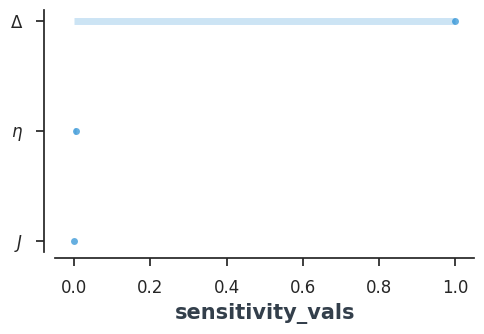

In [76]:
fig, ax = plt.subplots(figsize=(5,3.5))

plt.hlines(y=my_range, xmin=0, xmax=normalized_df, color='#007ACC', alpha=0.2, linewidth=5)
plt.plot(normalized_df, my_range, "o", markersize=5, color='#007ACC', alpha=0.6)
plt.yticks(my_range, df.index)
ax.set_xlabel('sensitivity_vals', fontsize=15, fontweight='black', color = '#333F4B')
ax.set_ylabel('')
ax.tick_params(axis='both', which='major', labelsize=12)
#ax.set_xlim(0,200)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 5))
plt.tight_layout()

plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "sensitivity_vals_obs.png"), dpi=300)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "sensitivity_vals_obs.eps"), dpi=300)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "sensitivity_vals_obs.svg"), dpi=300)

plt.show()

In [77]:
np.save(os.path.join(cwd+'/'+str(Res_dir), 'true_params_ode_Vfeatures100k_obs.npy'), true_params)
np.save(os.path.join(cwd+'/'+str(Res_dir), 'posterior_samples_ode_Vfeatures100k_obs.npy'), posterior_samples)
np.save(os.path.join(cwd+'/'+str(Res_dir), 'x_obs_ode_Vfeatures100k_obs.npy'), x_obs)
np.save(os.path.join(cwd+'/'+str(Res_dir), 'x_fit_ode_Vfeatures100k_obs.npy'), x_fit)